# World Happiness Report Analysis

In this notebook, we will perform an extensive analysis of the World Happiness Report datasets from 2015 to 2019. The analysis includes data cleaning, exploratory data analysis, dimensionality reduction, clustering, and geospatial analysis.

## 1. Importing Necessary Libraries


In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import geopandas as gpd
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from mpl_toolkits.axes_grid1 import make_axes_locatable
import plotly.express as px
import plotly.graph_objects as go
import umap
import warnings
warnings.filterwarnings("ignore")


## 2. Loading the Data
Here, we load the World Happiness Report datasets for the years 2015 to 2019.


In [2]:
# Loading the World Happiness Report datasets for the years 2015 to 2019
df_2015 = pd.read_csv('archive/2015.csv')
df_2016 = pd.read_csv('archive/2016.csv')
df_2017 = pd.read_csv('archive/2017.csv')
df_2018 = pd.read_csv('archive/2018.csv')
df_2019 = pd.read_csv('archive/2019.csv')


## 3. Standardizing Column Names
To ensure consistency across datasets, we standardize column names to a common format.


In [3]:
# Standardizing column names across datasets
def standardize_columns(df, year):
    if year in [2015, 2016]:
        df.rename(columns={
            'Happiness Rank': 'Rank',
            'Happiness Score': 'Score',
            'Economy (GDP per Capita)': 'GDP per Capita',
            'Health (Life Expectancy)': 'Life Expectancy',
            'Trust (Government Corruption)': 'Perceptions of corruption',
            'Family': 'Social Support',
            'Freedom': 'Freedom to make life choices'
        }, inplace=True)
    elif year == 2017:
        df.rename(columns={
            'Happiness.Rank': 'Rank',
            'Happiness.Score': 'Score',
            'Economy..GDP.per.Capita.': 'GDP per Capita',
            'Health..Life.Expectancy.': 'Life Expectancy',
            'Trust..Government.Corruption.': 'Perceptions of corruption',
            'Family': 'Social Support',
            'Freedom': 'Freedom to make life choices'
        }, inplace=True)
    else:
        df.rename(columns={
            'Overall rank': 'Rank',
            'Country or region': 'Country',
            'GDP per capita': 'GDP per Capita',
            'Social support': 'Social Support',
            'Healthy life expectancy': 'Life Expectancy',
            'Freedom to make life choices': 'Freedom to make life choices'
        }, inplace=True)
    df['Year'] = year
    return df

# Applying the standardization function to all datasets
df_2015 = standardize_columns(df_2015, 2015)
df_2016 = standardize_columns(df_2016, 2016)
df_2017 = standardize_columns(df_2017, 2017)
df_2018 = standardize_columns(df_2018, 2018)
df_2019 = standardize_columns(df_2019, 2019)


## 4. Concatenating Datasets
Combine the datasets into a single DataFrame for unified analysis.


In [4]:
# Selecting common columns
columns = ['Country', 'Rank', 'Score', 'GDP per Capita', 'Social Support', 
           'Life Expectancy', 'Freedom to make life choices', 'Generosity', 
           'Perceptions of corruption', 'Year']

# Concatenating the datasets into a single DataFrame
df = pd.concat([df_2015[columns], df_2016[columns], df_2017[columns], df_2018[columns], df_2019[columns]], ignore_index=True)


## 5. Initial Data Inspection
Check the first few rows and missing values in the dataset.


In [5]:
# Initial Data Inspection
print(df.head())

# Checking for missing values
print("Missing values:\n", df.isnull().sum())


       Country  Rank  Score  GDP per Capita  Social Support  Life Expectancy  \
0  Switzerland     1  7.587         1.39651         1.34951          0.94143   
1      Iceland     2  7.561         1.30232         1.40223          0.94784   
2      Denmark     3  7.527         1.32548         1.36058          0.87464   
3       Norway     4  7.522         1.45900         1.33095          0.88521   
4       Canada     5  7.427         1.32629         1.32261          0.90563   

   Freedom to make life choices  Generosity  Perceptions of corruption  Year  
0                       0.66557     0.29678                    0.41978  2015  
1                       0.62877     0.43630                    0.14145  2015  
2                       0.64938     0.34139                    0.48357  2015  
3                       0.66973     0.34699                    0.36503  2015  
4                       0.63297     0.45811                    0.32957  2015  
Missing values:
 Country                     

## 6. Handling Missing Values
Use KNN imputation to handle missing values instead of dropping rows.


In [6]:
from sklearn.impute import KNNImputer

# Handling missing values using KNN imputation
imputer = KNNImputer(n_neighbors=5)
df_clean = pd.DataFrame(imputer.fit_transform(df.select_dtypes(include=[np.number])), columns=df.select_dtypes(include=[np.number]).columns)
df_clean['Country'] = df['Country']
df_clean['Year'] = df['Year']


## 7. Outlier Detection
Detect and remove outliers using Isolation Forest.


In [7]:
from sklearn.ensemble import IsolationForest

# Checking for outliers using Isolation Forest
iso = IsolationForest(contamination=0.01, random_state=42)
outliers = iso.fit_predict(df_clean.select_dtypes(include=[np.number]))
df_clean = df_clean[outliers == 1]


## 8. Correlation Matrix
Visualize the correlation matrix using Plotly.


In [8]:
# Correlation Matrix with a Plotly Heatmap
correlations = df_clean.corr()
fig = px.imshow(correlations, text_auto=True, title='Correlation Matrix', color_continuous_scale='RdBu_r')
fig.show()


## 9. Univariate Analysis
Analyze the distribution of Happiness Scores and GDP per Capita.


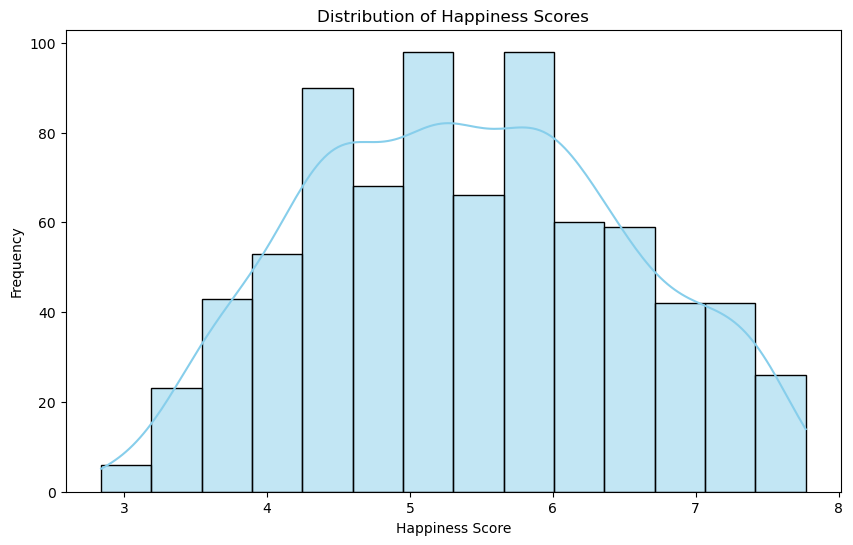

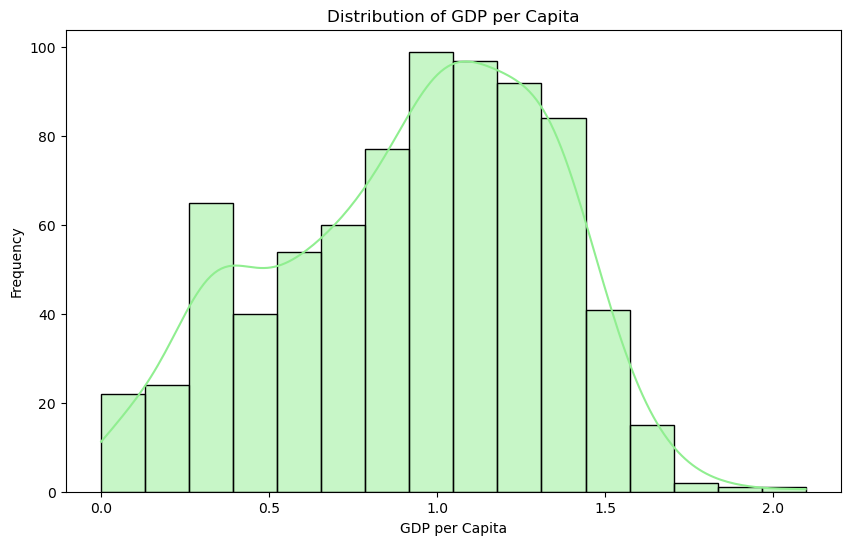

In [9]:
# Univariate Analysis: Distribution of Happiness Scores
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['Score'], kde=True, color='skyblue')
plt.title('Distribution of Happiness Scores')
plt.xlabel('Happiness Score')
plt.ylabel('Frequency')
plt.show()

# Univariate Analysis: Distribution of GDP per Capita
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['GDP per Capita'], kde=True, color='lightgreen')
plt.title('Distribution of GDP per Capita')
plt.xlabel('GDP per Capita')
plt.ylabel('Frequency')
plt.show()


## 10. Bivariate Analysis
Explore the relationship between Happiness Score and GDP per Capita, and Social Support.


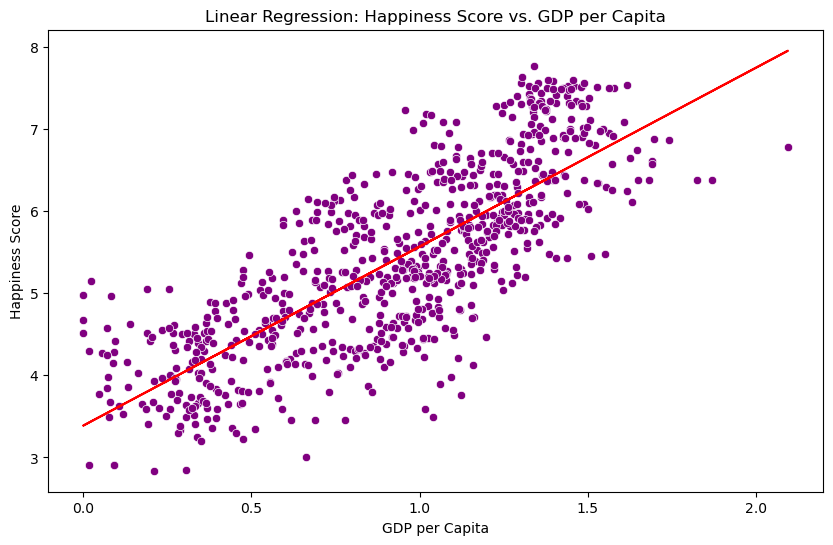

In [10]:
# Bivariate Analysis: Happiness Score vs. GDP per Capita
fig = px.scatter(
    df_clean,
    x='GDP per Capita',
    y='Score',
    size='Score',
    color='Year',
    title='Happiness Score vs GDP per Capita',
    trendline='ols',
    labels={'Score': 'Happiness Score', 'GDP per Capita': 'GDP per Capita'}
)
fig.show()

# Linear Regression Analysis: Happiness Score vs. GDP per Capita
X = df_clean['GDP per Capita'].values.reshape(-1, 1)
y = df_clean['Score'].values
regressor = LinearRegression()
regressor.fit(X, y)
y_pred = regressor.predict(X)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='GDP per Capita', y='Score', data=df_clean, color='purple')
plt.plot(df_clean['GDP per Capita'], y_pred, color='red')
plt.title('Linear Regression: Happiness Score vs. GDP per Capita')
plt.xlabel('GDP per Capita')
plt.ylabel('Happiness Score')
plt.show()

# Bivariate Analysis: Happiness Score vs. Social Support
fig = px.scatter(
    df_clean,
    x='Social Support',
    y='Score',
    size='Score',
    color='Year',
    title='Happiness Score vs Social Support',
    trendline='ols',
    labels={'Score': 'Happiness Score', 'Social Support': 'Social Support'}
)
fig.show()


## 11. Dimensionality Reduction
Perform PCA and t-SNE to reduce dimensions and visualize high-dimensional data.


In [11]:
# Principal Component Analysis (PCA)
features = ['GDP per Capita', 'Social Support', 'Life Expectancy', 'Freedom to make life choices', 'Generosity', 'Perceptions of corruption']
x = StandardScaler().fit_transform(df_clean[features])

pca = PCA(n_components=2)
principal_components = pca.fit_transform(x)

df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
df_pca['Country'] = df_clean['Country']
df_pca['Year'] = df_clean['Year']

fig = px.scatter(df_pca, x='PC1', y='PC2', text='Country', color='Year', title='PCA of Happiness Factors')
fig.show()

# t-SNE for Dimensionality Reduction
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(x)

df_tsne = pd.DataFrame(data=tsne_results, columns=['TSNE1', 'TSNE2'])
df_tsne['Country'] = df_clean['Country']
df_tsne['Year'] = df_clean['Year']

fig = px.scatter(df_tsne, x='TSNE1', y='TSNE2', text='Country', color='Year', title='t-SNE of Happiness Factors')
fig.show()


## 12. Clustering Analysis
Perform clustering and assess the quality using the Silhouette Score.


In [12]:
# Clustering Analysis
kmeans = KMeans(n_clusters=5, random_state=42)
df_clean['Cluster'] = kmeans.fit_predict(x)

# Calculate Silhouette Score
silhouette_avg = silhouette_score(x, df_clean['Cluster'])
print(f"Silhouette Score: {silhouette_avg}")

fig = px.scatter(df_clean, x='GDP per Capita', y='Score', color='Cluster', title='Clustering of Countries by Happiness Factors')
fig.show()


Silhouette Score: 0.23781055950320865


## 13. Geospatial Analysis
Visualize average happiness scores on a world map and use Plotly for interactive maps.


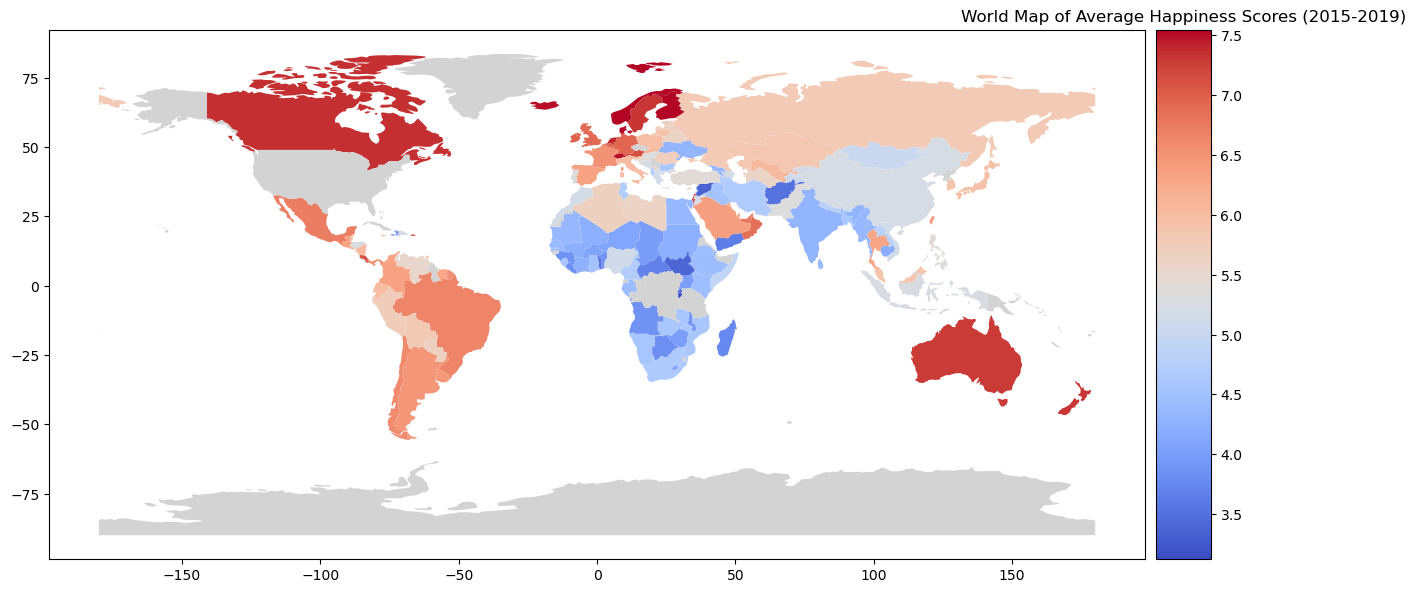

In [13]:
# Geospatial Analysis: World Map of Average Happiness Scores (2015-2019)
shapefile_path = 'ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp'
world = gpd.read_file(shapefile_path)
df_clean_geo = df_clean.groupby('Country')['Score'].mean().reset_index()
df_geo_merged = world.set_index('ADMIN').join(df_clean_geo.set_index('Country'))

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
df_geo_merged.plot(column='Score', ax=ax, legend=True, cax=cax, cmap='coolwarm', 
                   missing_kwds={'color': 'lightgrey'})
plt.title('World Map of Average Happiness Scores (2015-2019)')
plt.show()

# Dropdown menu for Plotly Choropleth Map
fig = go.Figure()

fig.add_trace(go.Choropleth(
    locations=df_clean['Country'],
    locationmode='country names',
    z=df_clean['Score'],
    colorscale='Viridis',
    colorbar_title='Happiness Score',
    visible=True
))

fig.update_layout(
    updatemenus=[{
        'buttons': [
            {
                'label': 'Happiness Score',
                'method': 'update',
                'args': [{'visible': [True]}]  
            }
        ],
        'direction': 'down',
        'showactive': True
    }]
)

fig.show()


## 14. Conclusions and Insights
Summarize the key findings and insights from the analysis.


In [14]:
# Conclusions and Insights
print("Key Insights:")
print("1. GDP per Capita is strongly correlated with happiness, but social factors also play a significant role.")
print(f"2. PCA suggests two principal components explain most variance in happiness scores.")
print(f"3. t-SNE and Clustering analysis reveal distinct groups of countries based on happiness factors, with a Silhouette Score of {silhouette_avg}.")
print("4. Geospatial analysis shows regional disparities in happiness, with wealthier regions generally ranking higher.")


Key Insights:
1. GDP per Capita is strongly correlated with happiness, but social factors also play a significant role.
2. PCA suggests two principal components explain most variance in happiness scores.
3. t-SNE and Clustering analysis reveal distinct groups of countries based on happiness factors, with a Silhouette Score of 0.23781055950320865.
4. Geospatial analysis shows regional disparities in happiness, with wealthier regions generally ranking higher.
